# Reconstruction

We can test various configurations of the reconstruction to try to find the best option. We can do this using a hyper-parameter search strategy which chooses the configuration that reduces a given error. For this we can could use a reprojection error and a grid search strategy.

For this test, and due to time constraints I will select the best one visually.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 195/195 [00:04<00:00, 48.59it/s]


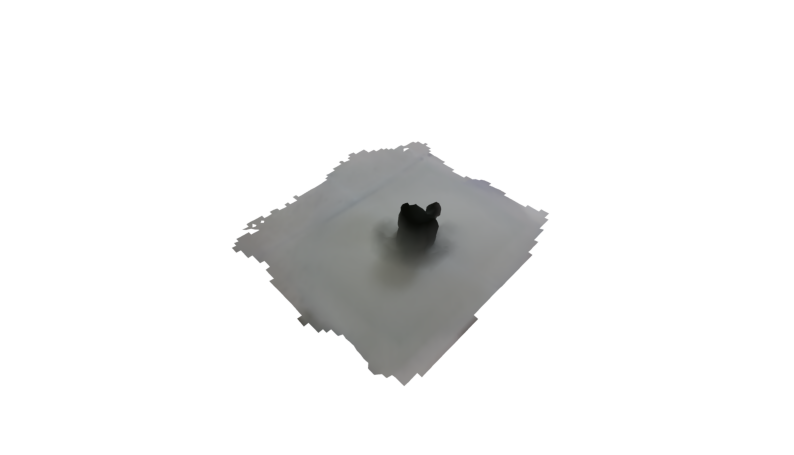

In [1]:
import open3d as o3d
import numpy as np
from reconstruction.dataset import Dataset
from reconstruction.config import Config
from reconstruction.reconstructor import Reconstructor
import reconstruction.utils.visualization as vis
from IPython.display import Markdown, display


dataset = Dataset.read("data/3d-scans-cap-black-glossy-ha-2019-02-27T16_06_29")
device = "CUDA:0" if o3d.core.cuda.is_available() else "CPU:0"

### How affects the voxel size?
We can see that with big voxels the details are lost but as we reduce the voxel size more gaps appear.

100%|██████████| 195/195 [00:22<00:00,  8.85it/s]


**Voxel size:** 0.001

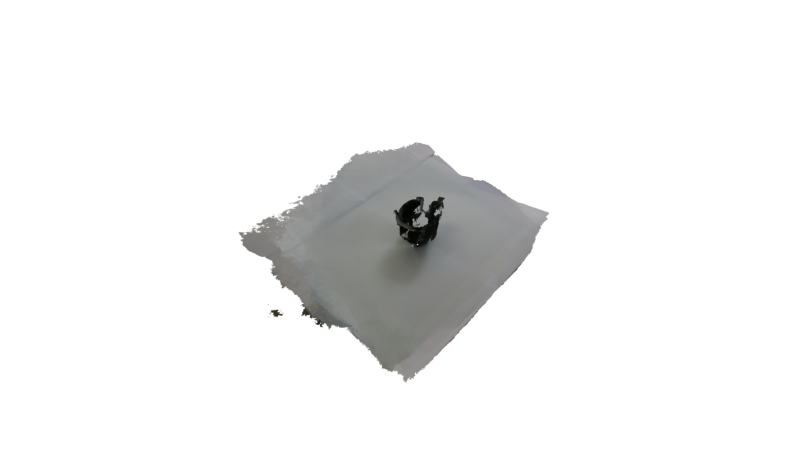

100%|██████████| 195/195 [00:04<00:00, 40.79it/s]


**Voxel size:** 0.005

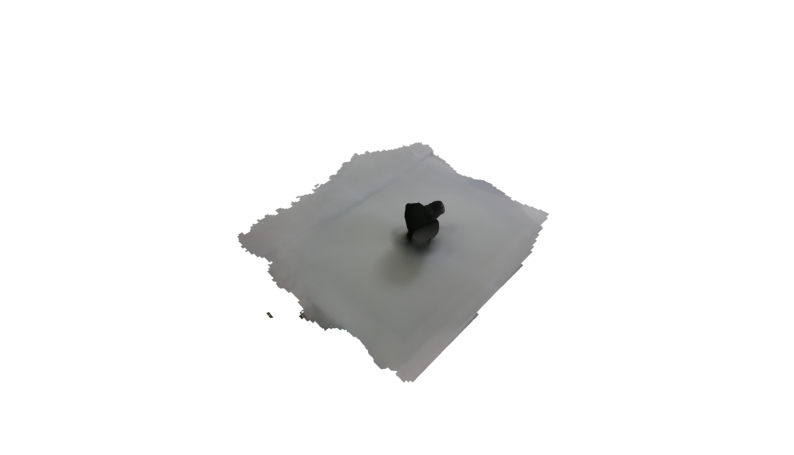

100%|██████████| 195/195 [00:03<00:00, 53.25it/s]


**Voxel size:** 0.01

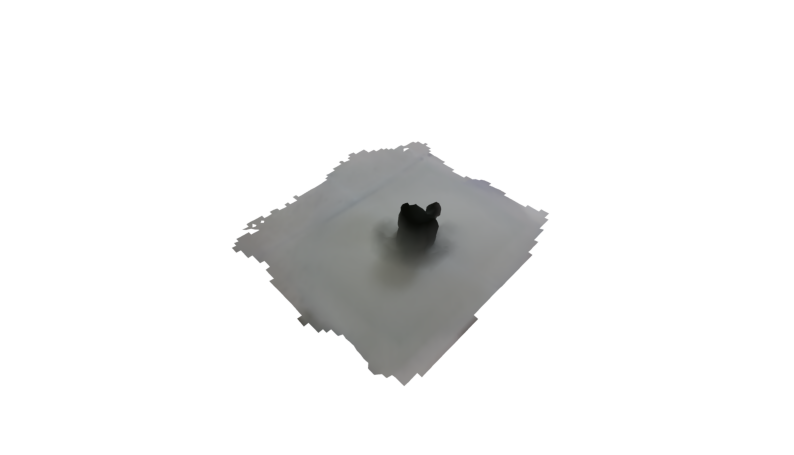

100%|██████████| 195/195 [00:03<00:00, 54.13it/s]


**Voxel size:** 0.02

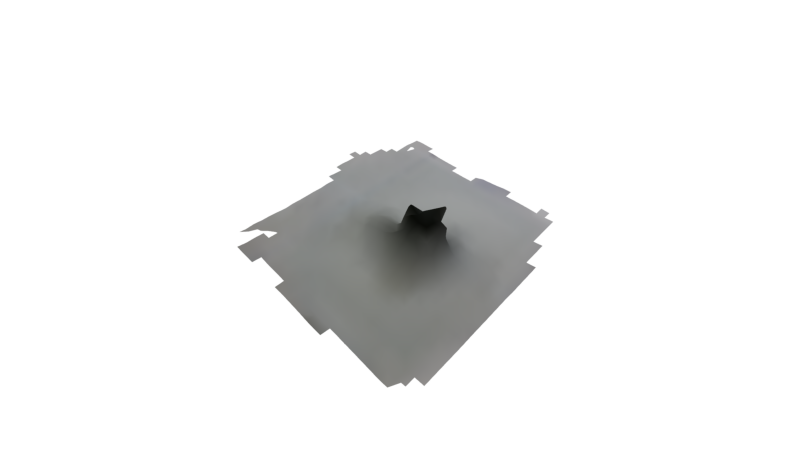

In [2]:

voxel_sizes=[0.001, 0.005, 0.01, 0.02]
for voxel_size in voxel_sizes:
    config = Config(
        device=device, 
        camera_intrinsic=np.array([[613.688, 0.0, 323.035], 
                                [0.0, 614.261, 242.229], 
                                [0.0, 0.0, 1.0]]), 
        voxel_size=voxel_size, 
        block_resolution=32, 
        block_count=5000,
        depth_scale=1000.0,
        depth_min=0.00,
        depth_max=0.6
    )

    reconstructor = Reconstructor(config)
    volume = reconstructor.reconstruct(dataset)
    mesh = volume.extract_triangle_mesh().to_legacy()

    display(Markdown(f"**Voxel size:** {voxel_size}"))
    vis.visualize_geometry([mesh], rotate=True)

### How affects the maximum depth?

100%|██████████| 195/195 [00:04<00:00, 43.66it/s]


**Max depth:** 0.5

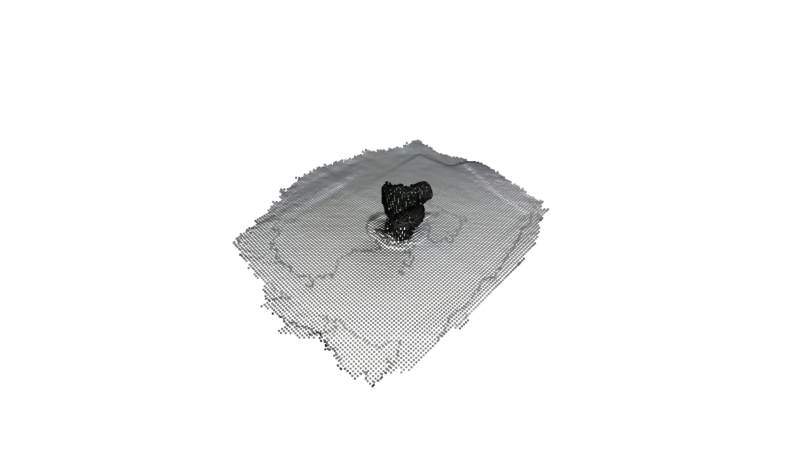

100%|██████████| 195/195 [00:05<00:00, 34.78it/s]


**Max depth:** 1.0

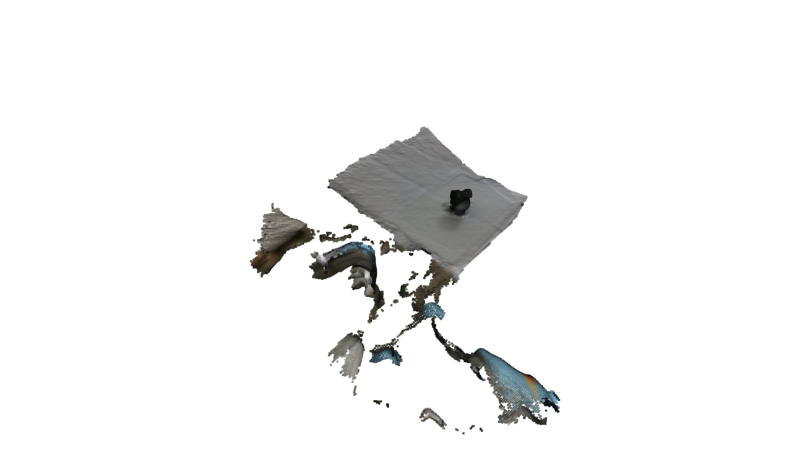

100%|██████████| 195/195 [00:07<00:00, 26.20it/s]


**Max depth:** 1.5

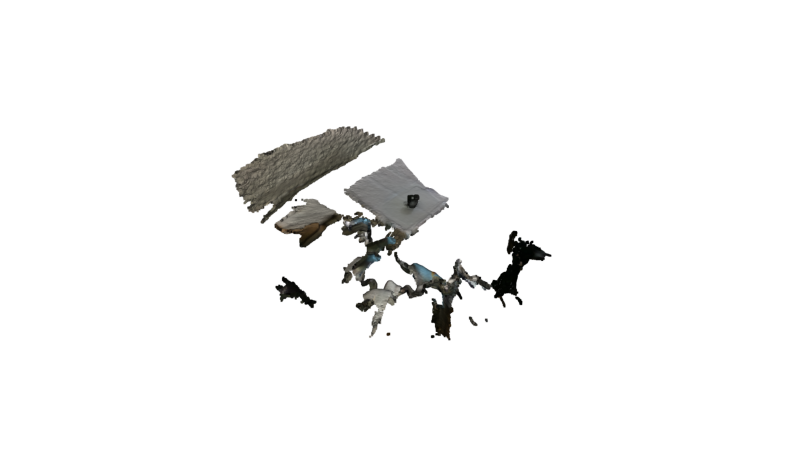

100%|██████████| 195/195 [00:10<00:00, 17.98it/s]


**Max depth:** 3.0

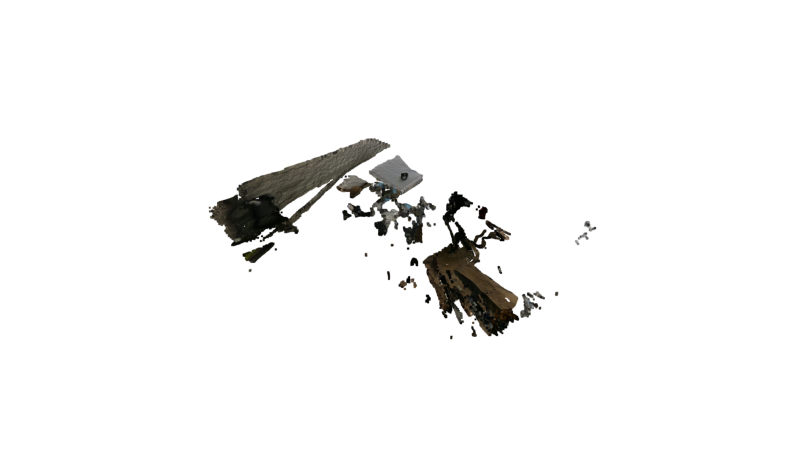

In [3]:

max_depths=[0.5, 1.0, 1.5, 3.0]
for max_depth in max_depths:
    config = Config(
        device=device, 
        camera_intrinsic=np.array([[613.688, 0.0, 323.035], 
                                [0.0, 614.261, 242.229], 
                                [0.0, 0.0, 1.0]]), 
        voxel_size=0.005, 
        block_resolution=32, 
        block_count=5000,
        depth_scale=1000.0,
        depth_min=0.00,
        depth_max=max_depth
    )

    reconstructor = Reconstructor(config)
    volume = reconstructor.reconstruct(dataset)
    mesh = volume.extract_point_cloud().to_legacy()

    display(Markdown(f"**Max depth:** {max_depth}"))
    vis.visualize_geometry([mesh], rotate=True)

## Using point cloud registration

100%|██████████| 195/195 [00:15<00:00, 12.29it/s]


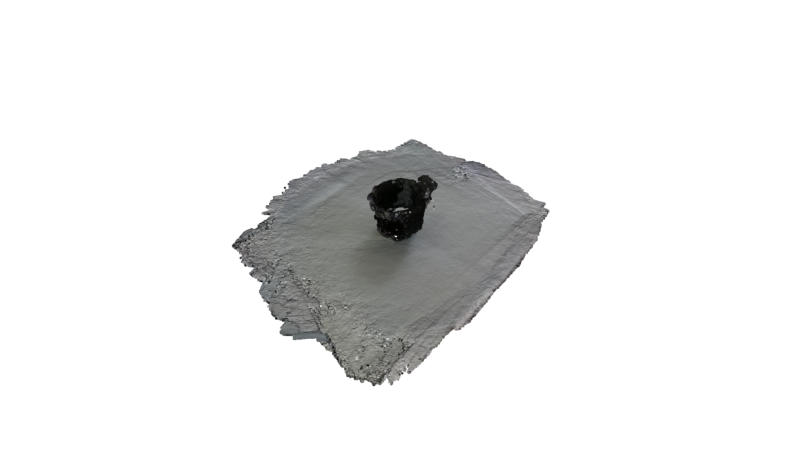

In [5]:

config = Config(
    device=device, 
    camera_intrinsic=np.array([[613.688, 0.0, 323.035], 
                            [0.0, 614.261, 242.229], 
                            [0.0, 0.0, 1.0]]), 
    voxel_size=0.001, 
    block_resolution=16, 
    block_count=10000,
    depth_scale=1000.0,
    depth_min=0.00,
    depth_max=0.5,
    register_point_clouds=True
)

reconstructor = Reconstructor(config)
volume = reconstructor.reconstruct(dataset)
mesh = volume.extract_point_cloud().to_legacy()

vis.visualize_geometry([mesh], rotate=True)
o3d.visualization.draw_geometries([mesh])

## Post processing

100%|██████████| 195/195 [00:34<00:00,  5.66it/s]


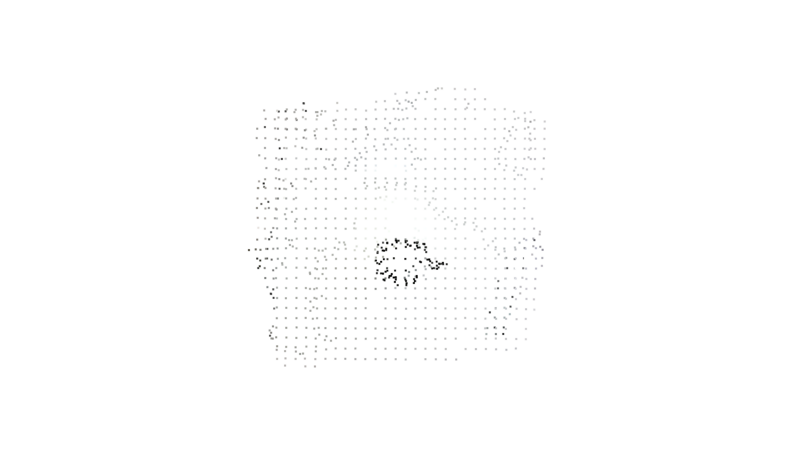

In [16]:
config = Config(
    device=device, 
    camera_intrinsic=np.array([[613.688, 0.0, 323.035], 
                            [0.0, 614.261, 242.229], 
                            [0.0, 0.0, 1.0]]), 
    voxel_size=0.001, 
    block_resolution=32, 
    block_count=5000,
    depth_scale=1000.0,
    depth_min=0.00,
    depth_max=0.6
)

reconstructor = Reconstructor(config)
volume = reconstructor.reconstruct(dataset)
point_cloud = volume.extract_point_cloud().to_legacy()
point_cloud = point_cloud.voxel_down_sample(voxel_size=0.02)

point_cloud, indices = point_cloud.remove_radius_outlier(nb_points=16, radius=0.05)
point_cloud = point_cloud.select_by_index(indices)

vis.visualize_geometry([point_cloud])
o3d.visualization.draw_geometries([point_cloud])